<a href="https://colab.research.google.com/github/valerian720/belman_ford_and_a_star_search_on_graph/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Реализовать программу, которая выполняет поиск на графе кратчайшего пути между двумя элементами при помощи алгоритмов Беллмана-Форда и А*.

In [ ]:
import sys
import numpy as np

# only for visualization, but could be used to study graphs
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
inf = 9999999
inf

9999999

In [ ]:
#@markdown input params for graph
graph_sise = 10 #@param {type: "slider", min: 2, max: 100}
min_value = 0 #@param {type: "slider", min: 0, max: 100}
max_value = 10 #@param {type: "slider", min: 0, max: 100}
threshold = 7 #@param {type: "slider", min: 0, max: 100}

In [ ]:
#@markdown class Graph
class Graph:
    def __init__(self, num_of_nodes, min_value, max_value, threshold):
        self.m_num_of_nodes = num_of_nodes

        # create random weights of graph
        self.adjacency_matrix = np.random.randint(min_value,max_value,(num_of_nodes,num_of_nodes))
        self.adjacency_matrix[self.adjacency_matrix <= threshold] = 0
        print("adjacency_matrix:\n", self.adjacency_matrix)
        self.m_graph = []

        # add edges
        [[self.add_edge(i, j, self.adjacency_matrix[i, j]) if self.adjacency_matrix[i, j] > 0 and i != j else 0 for j in range(num_of_nodes)] for i in range(num_of_nodes)]
        print(f"edges ({len(self.m_graph)}):\n",self.m_graph)
    def add_edge(self, node1, node2, weight):
        self.m_graph.append([node1, node2, weight])


In [ ]:
# only for visualization
def print_graph(graph_edges):
    G = nx.Graph()
    G.add_weighted_edges_from(graph_edges)

    pos=nx.spring_layout(G)
    nx.draw_networkx(G,pos)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [ ]:
class BellmanFordSearch:
    def __init__(self, graph):
        self.edges = graph.m_graph
        self.m_num_of_nodes = graph.m_num_of_nodes

    def search(self, start_node, end_node):
        self.depth = np.full(self.m_num_of_nodes, inf)
        self.callback_list = np.full(self.m_num_of_nodes, inf)
        # 
        self.depth[start_node] = 0
        #
        #  adjust min length per several iterations per each edge
        for i in range(1, self.m_num_of_nodes - 1):
            for edge in self.edges:
                self.relax(edge)
                print("relaxing edge:", edge)
                print("tmp d:", self.depth)
        for node1, node2, weight in self.edges:
            if self.depth[node2] > self.depth[node1] + weight:
                print("path not found")
                return False
        # 
        print("")
        if self.depth[end_node] == inf:
            print("path not found")
        else:
            self.extract_path(start_node, end_node)
        return True

    def relax(self, edge):
        # adjust min length based on edge data
        node1, node2, weight = edge
        if self.depth[node2] > self.depth[node1] + weight:
            self.depth[node2] = self.depth[node1] + weight
            self.callback_list[node2] = node1

    def extract_path(self, start_node, end_node):
        print(f"minimum length between {start_node} and {end_node}:", self.depth[end_node])
        # 
        search_head = end_node
        path = []
        while search_head != start_node:
            path.append(search_head)
            search_head = self.callback_list[search_head]
        # 
        path.append(start_node)
        print("path:", path[::-1])


In [ ]:
class AStarSearch:
    def __init__(self, graph):
        self.m_num_of_nodes = graph.m_num_of_nodes
        # 
        self.indexed_connections = {i:[] for i in range(self.m_num_of_nodes) }
        for edge in graph.m_graph:
            node1, node2, weight = edge
            self.indexed_connections[node1].append(edge)

    def __str__(self):
        return(f"weights: {self.weights}\ncallback_list: {self.callback_list}")

    def waterfall(self, start_node, end_node, start_value = 0, step_value = 1):
        distance = np.full(self.m_num_of_nodes, inf)
        distance[start_node] = start_value
        # 
        search_pool = [start_node]
        while not end_node in search_pool:
            active_node = search_pool.pop(0) # FIFO
            # 
            for node1, node2, weight in self.indexed_connections[active_node]:
                if distance[node2] == inf:
                  search_pool.append(node2)
                distance[node2] = min(distance[node2], distance[node1] + step_value)
        return distance

    def search(self, start_node, end_node):
        # 1) waterfall to create h(x) (with values from m_num_of_nodes to 0, by adding -1 on every fall)
        # 2) go through nodes and if there ara several paths choose with lowest f(x)
        # from the pool, then remove selected from pool and then add childs
        # f(x) = h(x) + weight on edge
        # 3) store weight of sum of edge per node
        # 4) extract path
        #////////////////////
        h = self.waterfall(start_node, end_node, self.m_num_of_nodes, -1) # idk how else to create h(x)
        print("h function: ", h)

        self.weights = np.full(self.m_num_of_nodes, inf)
        self.weights[start_node] = 0

        self.callback_list = np.full(self.m_num_of_nodes, inf)

        has_passed = np.full(self.m_num_of_nodes, False)
        search_pool = [start_node]
        while not end_node in search_pool:
            # 
            candidate_node = -1
            candidate_node_weight = inf
            for research_node in search_pool:
                is_fully_searched = True
                for node1, node2, weight in self.indexed_connections[research_node]:
                    f = h[node2] + weight # check f(x)
                    if not has_passed[node2]:
                        print(f"edge: {node1}-{node2} h(x): {h[node2]} g(x): {weight} f(x): {f}")

                    if f < candidate_node_weight and not has_passed[node2]: 
                        candidate_node = node2
                        candidate_node_weight = f
                        self.weights[node2] = min(self.weights[node2], weight + self.weights[node1])
                        self.callback_list[node2] = node1

                    if not has_passed[candidate_node]:
                      is_fully_searched = False

                if is_fully_searched:
                    search_pool.remove(research_node)
            print("candidate_node", candidate_node)
            has_passed[candidate_node] = True
            search_pool.append(candidate_node)
            print("search_pool:", search_pool)

        print("")
        self.extract_path(start_node, end_node)

    def extract_path(self, start_node, end_node):
        print(f"minimum length between {start_node} and {end_node}:", self.weights[end_node])
        
        search_head = end_node
        path = []
        while search_head != start_node:
            path.append(search_head)
            search_head = self.callback_list[search_head]
        # 
        path.append(start_node)
        print("path:", path[::-1])
      

adjacency_matrix:
 [[0 0 0 9 0 9 0 0 0 0]
 [0 0 9 0 0 0 9 0 8 9]
 [0 0 0 0 0 8 0 0 9 0]
 [0 8 9 0 0 9 0 0 9 0]
 [0 0 0 9 9 0 0 8 0 0]
 [0 8 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
edges (16):
 [[0, 3, 9], [0, 5, 9], [1, 2, 9], [1, 6, 9], [1, 8, 8], [1, 9, 9], [2, 5, 8], [2, 8, 9], [3, 1, 8], [3, 2, 9], [3, 5, 9], [3, 8, 9], [4, 3, 9], [4, 7, 8], [5, 1, 8], [8, 3, 9]]


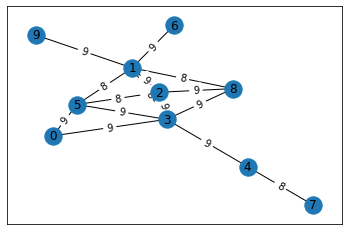

In [ ]:
# create random graph
random_graph = Graph(graph_sise, min_value, max_value, threshold)
print_graph(random_graph.m_graph)

In [ ]:
bellman_ford = BellmanFordSearch(random_graph)

In [ ]:

#@markdown input params for Bellman - Ford search
start_node = 0 #@param {type: "slider", min: 0, max: 100}
end_node = 6 #@param {type: "slider", min: 0, max: 100}

bellman_ford.search(start_node, end_node)
print("")
print("d:",bellman_ford.depth)
print("pi:",bellman_ford.callback_list)

relaxing edge: [0, 3, 9]
tmp d: [      0 9999999 9999999       9 9999999 9999999 9999999 9999999 9999999
 9999999]
relaxing edge: [0, 5, 9]
tmp d: [      0 9999999 9999999       9 9999999       9 9999999 9999999 9999999
 9999999]
relaxing edge: [1, 2, 9]
tmp d: [      0 9999999 9999999       9 9999999       9 9999999 9999999 9999999
 9999999]
relaxing edge: [1, 6, 9]
tmp d: [      0 9999999 9999999       9 9999999       9 9999999 9999999 9999999
 9999999]
relaxing edge: [1, 8, 8]
tmp d: [      0 9999999 9999999       9 9999999       9 9999999 9999999 9999999
 9999999]
relaxing edge: [1, 9, 9]
tmp d: [      0 9999999 9999999       9 9999999       9 9999999 9999999 9999999
 9999999]
relaxing edge: [2, 5, 8]
tmp d: [      0 9999999 9999999       9 9999999       9 9999999 9999999 9999999
 9999999]
relaxing edge: [2, 8, 9]
tmp d: [      0 9999999 9999999       9 9999999       9 9999999 9999999 9999999
 9999999]
relaxing edge: [3, 1, 8]
tmp d: [      0      17 9999999       9 9999999       9

In [ ]:
a_star = AStarSearch(random_graph)

In [ ]:
#@markdown input params for A* search
start_node = 0 #@param {type: "slider", min: 0, max: 100}
end_node = 6 #@param {type: "slider", min: 0, max: 100}

a_star.search(start_node, end_node)

h function:  [     10       7       6       9 9999999       8       6 9999999       6
       6]
edge: 0-3 h(x): 9 g(x): 9 f(x): 18
edge: 0-5 h(x): 8 g(x): 9 f(x): 17
candidate_node 5
search_pool: [0, 5]
edge: 0-3 h(x): 9 g(x): 9 f(x): 18
edge: 5-1 h(x): 7 g(x): 8 f(x): 15
candidate_node 1
search_pool: [0, 5, 1]
edge: 0-3 h(x): 9 g(x): 9 f(x): 18
edge: 1-2 h(x): 6 g(x): 9 f(x): 15
edge: 1-6 h(x): 6 g(x): 9 f(x): 15
edge: 1-8 h(x): 6 g(x): 8 f(x): 14
edge: 1-9 h(x): 6 g(x): 9 f(x): 15
candidate_node 8
search_pool: [0, 5, 1, 8]
edge: 0-3 h(x): 9 g(x): 9 f(x): 18
edge: 1-2 h(x): 6 g(x): 9 f(x): 15
edge: 1-6 h(x): 6 g(x): 9 f(x): 15
edge: 1-9 h(x): 6 g(x): 9 f(x): 15
edge: 8-3 h(x): 9 g(x): 9 f(x): 18
candidate_node 2
search_pool: [0, 5, 1, 8, 2]
edge: 0-3 h(x): 9 g(x): 9 f(x): 18
edge: 1-6 h(x): 6 g(x): 9 f(x): 15
edge: 1-9 h(x): 6 g(x): 9 f(x): 15
edge: 8-3 h(x): 9 g(x): 9 f(x): 18
candidate_node 6
search_pool: [0, 5, 1, 8, 2, 6]

minimum length between 0 and 6: 26
path: [0, 5, 1, 6]


In [ ]:
print(a_star)

weights: [      0      17      26       9 9999999       9      26 9999999      25
 9999999]
callback_list: [9999999       5       1       0 9999999       0       1 9999999       1
 9999999]
